In [1]:
import os
from glob import glob
from warnings import simplefilter

In [2]:
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

#### Configure path parameters and read data files

The `RANDOM_SEED`, `NUM_EPOCHS`, `TRAIN_FRAC`, and `VAL_FRAC` are the same for all models during evaluaiton

In [3]:
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), *['..'] * 1)) 
IMAGES_DIR = os.path.join(ROOT_DIR, "data", "datasets", "aircraft", "images")

RADOM_SEED = 2020
TRAIN_FRAC = 0.8
VAL_FRAC = 0.1

NUM_EPOCHS = 20

In [4]:
image_dir = IMAGES_DIR
labels_fp = os.path.join(ROOT_DIR, "data", "datasets", "aircraft", "annotations.csv")

#### Load utility functions

In [5]:
os.chdir(ROOT_DIR)

In [6]:
import torch
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

from src.utilities.data.aircraft_dataloader import get_dataloader

#### Define a minimal transformation pipeline

In [7]:
transformations = A.Compose([
  A.Resize(256, 256),  # This transform resizes each image before subsequent processing
  A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # This transformation normalizes from standard RGB to grayscale
  ToTensorV2(),  # This transform maps our image to a torch.Tensor object
])


#### Load the baseline models

In [8]:
from src.models.baseline.cnn import BaselineCNN
from src.models.baseline.mlp import BaselineMLP
from src.models.baseline.linear import SingleLinearLayer

#### Define evaluation configuration

In [9]:
default_criterion = nn.MSELoss()

baseline_cnn = BaselineCNN()
optimizer_cnn = torch.optim.Adam(baseline_cnn.parameters(), lr=0.01)

baseline_mlp = BaselineMLP()
optimizer_mlp = torch.optim.Adam(baseline_mlp.parameters(), lr=0.01)

single_linear_layer = SingleLinearLayer()
optimizer_linear_layer = torch.optim.Adam(single_linear_layer.parameters(), lr=0.01)

In [10]:
model_configurations = {
  "Baseline CNN": {
    "model": baseline_cnn,
    "transformations": transformations,
    "optimizer": optimizer_cnn,
    "criterion": default_criterion,
    "dataloader_kwargs": {
      "batch_size": 4,
      "shuffle": True,
    },
  },
  "Baseline MLP": {
    "model": baseline_mlp,
    "transformations": transformations,
    "optimizer": optimizer_mlp,
    "criterion": default_criterion,
    "dataloader_kwargs": {
      "batch_size": 4,
      "shuffle": True,
    },
  },
}

### Train the models

In [11]:
for model_name, model_config in model_configurations.items():

  dataloader = get_dataloader(
    image_dir=image_dir,
    labels_fp=labels_fp,
    transformations=model_config["transformations"],
    mode='train',
    train_frac=TRAIN_FRAC,
    val_frac=VAL_FRAC,
    seed=RADOM_SEED,
    batch_size=model_config["dataloader_kwargs"]["batch_size"],
    shuffle=model_config["dataloader_kwargs"]["shuffle"],
    num_workers=1,
  )

  # Training loop
  for epoch in range(NUM_EPOCHS):
    for i, (images, targets) in enumerate(dataloader):
      # Forward pass
      outputs = model_config["model"](images)
      loss = model_config["criterion"](outputs.squeeze(), targets)  # Ensure outputs are squeezed to match counts shape

      # Backward pass and optimization
      model_config["optimizer"].zero_grad()
      loss.backward()
      model_config["optimizer"].step()

    print(f"Model {model_name} epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}")


Model Baseline CNN epoch [1/20], Loss: 4356.0000
Model Baseline CNN epoch [2/20], Loss: 41.6818
Model Baseline CNN epoch [3/20], Loss: 187.7022
Model Baseline CNN epoch [4/20], Loss: 937.6151
Model Baseline CNN epoch [5/20], Loss: 266.8334
Model Baseline CNN epoch [6/20], Loss: 61.9824
Model Baseline CNN epoch [7/20], Loss: 117.4381
Model Baseline CNN epoch [8/20], Loss: 6.5623
Model Baseline CNN epoch [9/20], Loss: 10.4716
Model Baseline CNN epoch [10/20], Loss: 96.1152
Model Baseline CNN epoch [11/20], Loss: 8.9514
Model Baseline CNN epoch [12/20], Loss: 9.0491
Model Baseline CNN epoch [13/20], Loss: 4.1525
Model Baseline CNN epoch [14/20], Loss: 0.5735
Model Baseline CNN epoch [15/20], Loss: 0.7779
Model Baseline CNN epoch [16/20], Loss: 1.7460
Model Baseline CNN epoch [17/20], Loss: 1.8805
Model Baseline CNN epoch [18/20], Loss: 1.9219
Model Baseline CNN epoch [19/20], Loss: 0.6020
Model Baseline CNN epoch [20/20], Loss: 1.4162
Model Baseline MLP epoch [1/20], Loss: 977.0000
Model 

### Evaluate the models

In [12]:
model_losses = {
  model_name: [] for model_name in model_configurations.keys()
}
model_predictions = {
  model_name: [] for model_name in model_configurations.keys()
}


In [13]:
for model_name, model_config in model_configurations.items():
  val_dataloader = get_dataloader(
    image_dir,
    labels_fp,
    transformations=transformations,
    mode='val',
    train_frac=TRAIN_FRAC,
    val_frac=VAL_FRAC,
    seed=RADOM_SEED,
    batch_size=1,
    shuffle=False,
    num_workers=1,
  )
  true_labels = []

  for i, (val_images, targets) in enumerate(val_dataloader):
    predicted_counts = model_config["model"](val_images)
    # We validate based on the mean absolute error
    model_losses[model_name].append(torch.abs(predicted_counts - targets).item())
    model_predictions[model_name].append(predicted_counts.item())
    true_labels.append(targets.item())
    print(f"{model_name} - val image {i+1}, predicted count: {predicted_counts.item():.4f}, true count: {targets.item():.4f}")


Baseline CNN - val image 1, predicted count: 23.2693, true count: 31.0000
Baseline CNN - val image 2, predicted count: 24.3161, true count: 24.0000
Baseline CNN - val image 3, predicted count: 34.4717, true count: 19.0000
Baseline CNN - val image 4, predicted count: 60.6688, true count: 49.0000
Baseline CNN - val image 5, predicted count: 22.9901, true count: 27.0000
Baseline CNN - val image 6, predicted count: 6.2221, true count: 15.0000
Baseline CNN - val image 7, predicted count: 23.2017, true count: 30.0000
Baseline CNN - val image 8, predicted count: 69.5394, true count: 52.0000
Baseline CNN - val image 9, predicted count: 21.7396, true count: 39.0000
Baseline CNN - val image 10, predicted count: 11.8935, true count: 26.0000
Baseline MLP - val image 1, predicted count: 0.0000, true count: 31.0000
Baseline MLP - val image 2, predicted count: 0.0000, true count: 24.0000
Baseline MLP - val image 3, predicted count: 0.0000, true count: 19.0000
Baseline MLP - val image 4, predicted cou

### Compare the models

In [14]:
for model_name, model_losses in model_losses.items():
  print(f"Model {model_name} MAE: {sum(model_losses) / len(model_losses):.4f}")


Model Baseline CNN MAE: 10.3680
Model Baseline MLP MAE: 31.2000


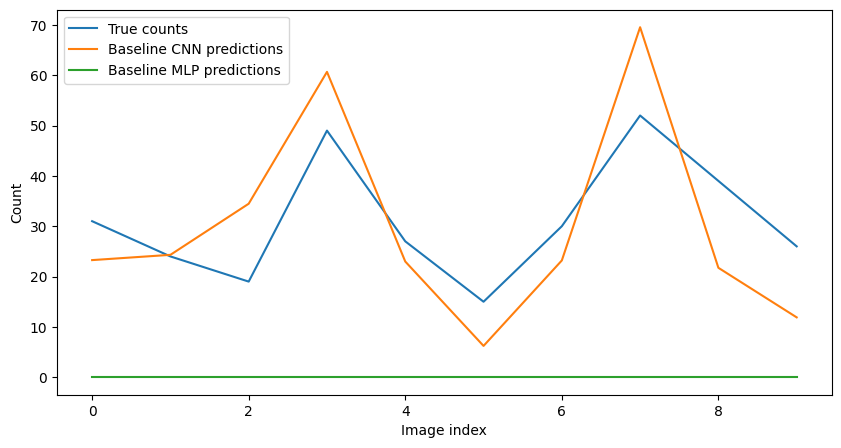

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(true_labels, label="True counts")
for model_name, model_predictions in model_predictions.items():
  plt.plot(model_predictions, label=f"{model_name} predictions")
plt.xlabel("Image index")
plt.ylabel("Count")
plt.legend()
plt.show()
